# Analyzing performance of Shape Predictor

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import statistics

In [26]:
def read_lmfile(inputfile):
        
        """Parse tps or txt file that contains landmarks
        
        Returns:
            self.lm_dict (Dict): Dictionary that contains flip_images (basename) as keys and landmarks as values
            self.img_list (List): List of flip_images (basename)
            Landmarks.nested_dict (Dict): Nested Dictionary with ID, SCALE and LM for every image (og_name)
        """
        landmarks_dict = {}
        landmarks = []
        image_list = []
        check = False
        with open(inputfile, 'r') as file:
      
            for line in file:
                
                # Process expected line, "LANDMARKS" 
                if line.startswith("LM"):
                    n_lm = int(line.strip().split('=')[1])
                    
                    if n_lm == 0:
                        print(f"WARNING: No landmarks annotated for this image")
                    
                    # Read all the landmarks
                    else: 
                        check = False
                        i = 0
                        lm_list = []
                        while i < n_lm:
                            landmark_line = next(file).strip().split() 
                            lm = [float(landmark_line[0]), float(landmark_line[1])]
                            lm_list.append(lm)
                            i+=1
                    if n_lm != 12:
                        print(f"What the fuck happens here")
                        check = True
                    else: 
                        check = False
                        

                    # Process the next expected line, "IMAGE"
                    next_line = file.readline()
                    
                    if next_line.startswith("IMAGE"):
                        image_name = str(next_line.strip().split('=')[1])
                        image_list.append(image_name)
                        landmarks_dict[image_name] = {}
                        landmarks.append(lm_list)
                        if check == True:
                            print(f'Image {image_name} has only {n_lm} landmarks annotated')
                        else:
                            for i, lm in enumerate(lm_list):
                                landmarks_dict[image_name][i] = lm
                                            
                    # Process the next expected line, "ID"
                    next_line = file.readline()
                    
                    if next_line.startswith("ID"):
                        real_id = str(next_line.strip().split('=')[1])
                    
                    # Process the next expected line, "SCALE"
                    next_line = file.readline()
                    
                    if next_line.startswith("SCALE"):
                        scale = next_line.strip()
        
        return np.array(landmarks), image_list, dict(sorted(landmarks_dict.items()))

In [27]:
prediction_file = '/Users/luciamf/Desktop/Landmarks_generator/example/carabus_1_landmarks/carabus_1_landmarks.txt'
train_file = '/Users/luciamf/Desktop/Landmarks_generator/example/Carabus_pronotum_train.txt'

In [28]:
pred_landmarks, image_pred, pred_dict = read_lmfile(prediction_file)
real_landmarks, image_real, real_dict = read_lmfile(train_file)

In [29]:
len(pred_landmarks), len(real_landmarks),len(image_real), len(image_pred)

(319, 319, 319, 319)

In [30]:
def get_xy(landmarks):
    x_list = []
    y_list = []
    for coor in landmarks:
        for x,y in coor:
            x_list.append(x)
            y_list.append(y)
    return x_list,y_list

set 1: [[1131. 1774.]
 [1738. 1719.]
 [2727.  616.]
 [1763.  524.]
 [2331. 1779.]
 [2542.  261.]
 [ 977.  258.]
 [1355.  510.]
 [2166.  501.]
 [ 777. 1445.]
 [2708. 1447.]
 [ 763.  644.]]
set 2: [[1152. 1770.]
 [1741. 1712.]
 [2325. 1777.]
 [2543.  257.]
 [ 959.  259.]
 [1367.  519.]
 [2121.  519.]
 [ 836. 1538.]
 [2678. 1494.]
 [ 757.  691.]
 [2750.  698.]
 [1748.  508.]]
set 1: [[1203. 1749.]
 [1811. 1722.]
 [2835.  799.]
 [1789.  455.]
 [2449. 1729.]
 [2567.  251.]
 [ 996.  290.]
 [1369.  468.]
 [2202.  439.]
 [ 897. 1529.]
 [2751. 1485.]
 [ 765.  876.]]
set 2: [[1199. 1749.]
 [1806. 1726.]
 [2453. 1726.]
 [2564.  252.]
 [ 999.  289.]
 [1368.  465.]
 [2195.  444.]
 [ 890. 1522.]
 [2758. 1471.]
 [ 770.  864.]
 [2830.  794.]
 [1783.  456.]]


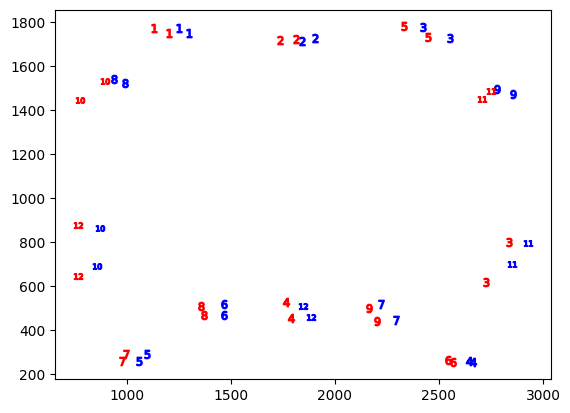

In [31]:
def plot_shape(landmarks1, landmarks2):
    for j in range(len(landmarks1)):
        i = 0
        print(f'set 1: {landmarks1[j]}')
        print(f'set 2: {landmarks2[j]}')
        for x,y in landmarks1[j]:
            i+=1
            plt.scatter(x,y, color ='red', marker="$"+str(i)+"$")
        i = 0
        for x,y in landmarks2[j]:
            i+=1
            plt.scatter(x+100,y, color = 'blue', marker="$"+str(i)+"$")
        if j == 1:
            break
plot_shape(pred_landmarks, real_landmarks)

In [32]:
x_pred,y_pred = get_xy(pred_landmarks)
x_real,y_real = get_xy(real_landmarks)

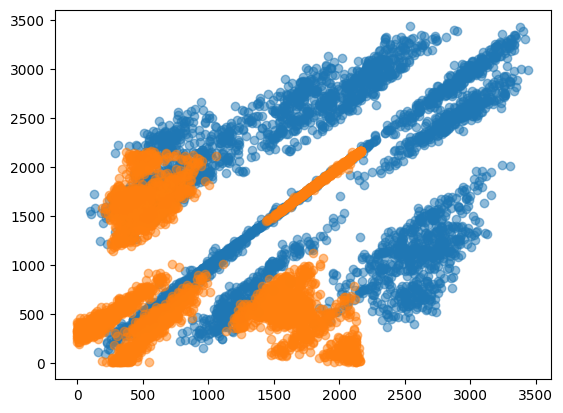

In [33]:

plt.scatter(x_pred, x_real, alpha = 0.5)
plt.scatter(y_pred, y_real, alpha = 0.5)

Tiene pinta de que estan ordenadas diferente las landmarks

In [34]:


def determine_optimal_reordering(set1, set2):
    # Calculate the pairwise distance matrix
    distance_matrix = np.linalg.norm(set1[:, np.newaxis] - set2, axis=2)

    # Use the Hungarian algorithm to find the optimal assignment
    row_indices, col_indices = linear_sum_assignment(distance_matrix)

    return col_indices

def calculate_errors(real_shapes, measured_shapes, optimal_order):
    errors = []
    
    for real_shape, measured_shape in zip(real_shapes, measured_shapes):
        reordered_measured_shape = measured_shape[optimal_order]
        error = np.linalg.norm(real_shape - reordered_measured_shape, axis=1)
        errors.append(error)
    
    return errors

In [35]:
# Determine the optimal reordering using the first shape pair
optimal_order = determine_optimal_reordering(real_landmarks[0], pred_landmarks[0])

# Calculate the errors for all shapes using the optimal reordering
errors = calculate_errors(real_landmarks, pred_landmarks, optimal_order)

# Print the results
error_list = []
j = 0
for i, error in enumerate(errors):
    error_list.append(float(error.mean()))
    # print(f"Shape {i+1} errors: {error}")
    # print(f"Total error for Shape {i+1}: {error.mean()}")
    # if i > 5:
    #     break

mean = statistics.mean(error_list)

print(mean)

17.24959321975782


Mp soy capaz de reproducir el error: /Users/luciamf/Desktop/Landmarks_generator/example/all_data.xml MAE of the model: /Users/luciamf/Desktop/Landmarks_generator/example/carabus_1.dat is 15.267509845362888, vs 17.24959321975782